Last Modifed:July 23, 2019

Description: This notebook builds a simple neural network and trains it. The data used is from a Kaggle dataset (Intel Image Classification).

This one uses tensorflow and keras layers.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import platform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import normalize
import time

print('python: ', platform.python_version())
print('tensorflow: ', tf.__version__)

python:  3.6.8
tensorflow:  1.13.1


Declare paths to data.

In [2]:
training_path='seg_train'
test_path='seg_test'

In [3]:
class_dict={}
for i in os.listdir(training_path):
    class_dict[i] =  os.listdir(training_path+'/'+i)

In [4]:
img_list=[]
class_list=[]
classes=[]
dr=[]

In [5]:
for ii in class_dict:
    classes.append(ii)

In [6]:
for ii,val in enumerate(class_dict.values()):
    for img in val :
        img_list.append(img)
        class_list.append(classes[ii])

In [7]:
for ii in range(len(class_list)):
    dr.append(training_path+'/'+class_list[ii]+'/'+img_list[ii])

The transformations of flipping horizontally and vertically as well as rotations up to 25 degrees are set for the training set. Both the test and training sets are normalized to [0,1] for the pixel values.

In [8]:
train_data_generator=ImageDataGenerator(rescale=1.0/255,rotation_range=25,horizontal_flip=True,vertical_flip=True)

test_data_generator=ImageDataGenerator(rescale=1.0/255)

The batch size is declared and the images resized to 150x150.

Then the number of images for training and testing are reported.

In [9]:
batch_size=64 

train_generator=train_data_generator.flow_from_directory(training_path,target_size = (150,150),
                                                         batch_size=batch_size,class_mode='sparse',shuffle=True)

test_generator=test_data_generator.flow_from_directory(test_path,target_size=(150,150),
                                                       batch_size=batch_size,class_mode='sparse',shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


The model is built using keras layers which handles most of the complexity.

model=keras.Sequential()

model.add(Conv2D(32, kernel_size=(3,3), strides=2, activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), strides=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(len(classes), activation='softmax'))

model.summary()

The model is then compiled with a loss function, optimizer, and metric.

In [11]:
training_count=len(img_list)
print(training_count)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

14034


The model is trained for 15 epochs.

In [12]:
t = time.time()

history=model.fit_generator(train_generator,epochs=15,steps_per_epoch=training_count//batch_size,
                            shuffle=True,verbose=1,validation_data=test_generator)

elapsed = time.time() - t


Epoch 1/15
220/220 [==============================] - 64s 289ms/step - loss: 1.3002 - acc: 0.4601 - val_loss: 1.2707 - val_acc: 0.5210
Epoch 2/15
220/220 [==============================] - 65s 296ms/step - loss: 1.0530 - acc: 0.5912 - val_loss: 1.0005 - val_acc: 0.6297
Epoch 3/15
220/220 [==============================] - 62s 284ms/step - loss: 0.9426 - acc: 0.6479 - val_loss: 0.8089 - val_acc: 0.6923
Epoch 4/15
220/220 [==============================] - 62s 284ms/step - loss: 0.8867 - acc: 0.6751 - val_loss: 0.7754 - val_acc: 0.7117
Epoch 5/15
220/220 [==============================] - 65s 293ms/step - loss: 0.8170 - acc: 0.6993 - val_loss: 0.7322 - val_acc: 0.7353
Epoch 6/15
220/220 [==============================] - 63s 284ms/step - loss: 0.7866 - acc: 0.7158 - val_loss: 0.7311 - val_acc: 0.7377
Epoch 7/15
220/220 [==============================] - 63s 284ms/step - loss: 0.7583 - acc: 0.7328 - val_loss: 0.6796 - val_acc: 0.7510
Epoch 8/15
220/220 [==============================] - 6

In [13]:
print('Training Time:', elapsed)

Training Time: 949.0090763568878


I plot the accuracy and loss.

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

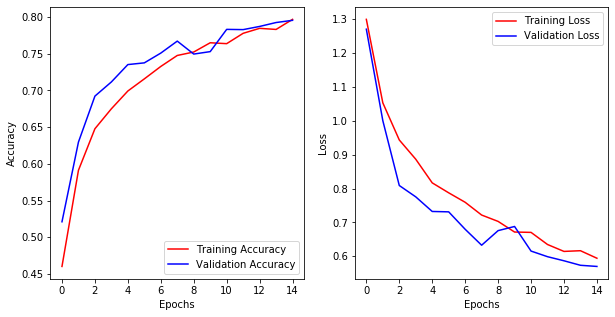

In [14]:
# Loss Curves
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.plot(history.history['acc'],'r',label='Training Accuracy')
ax1.plot(history.history['val_acc'],'b',label='Validation Accuracy')
ax1.legend()
ax1.set(xlabel='Epochs',ylabel='Accuracy')

ax2.plot(history.history['loss'],'r',label='Training Loss')
ax2.plot(history.history['val_loss'],'b',label='Validation Loss')
ax2.legend()
ax2.set(xlabel='Epochs',ylabel='Loss')

The trained model then predicts labels.

In [15]:
pred=model.predict_classes(test_generator)
test_labels=test_generator.classes

A confusion matrix is a useful visualization tool to see correct and incorrect classifications.

In [16]:
conf=confusion_matrix(test_labels,pred)

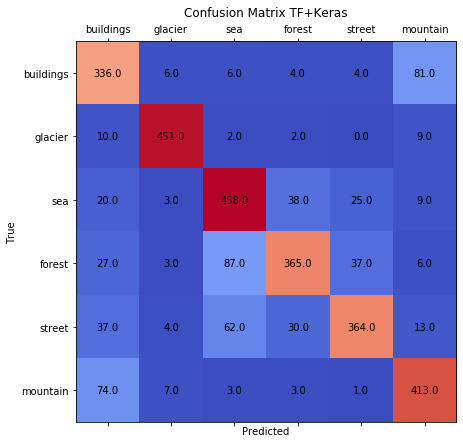

In [17]:
fig, ax = plt.subplots(figsize=(7,7))
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(conf, cmap='coolwarm')
ax.set_xticklabels(['']+classes)
ax.set_yticklabels(['']+classes)
plt.title('Confusion Matrix TF+Keras')
plt.xlabel('Predicted')
plt.ylabel('True')

for (ii, jj), val in np.ndenumerate(conf):
    ax.text(jj, ii, '{:0.1f}'.format(val), ha='center', va='center')

plt.show()

A classification report is made to report extra metrics for optional further comparison.

In [18]:
CR=classification_report(test_labels,pred)

print(CR)

              precision    recall  f1-score   support

           0       0.67      0.77      0.71       437
           1       0.95      0.95      0.95       474
           2       0.74      0.83      0.78       553
           3       0.83      0.70      0.75       525
           4       0.84      0.71      0.77       510
           5       0.78      0.82      0.80       501

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



Lastly, the accuracy is reported and the final accuracy and training time are saved for comparison.

In [19]:
acc=accuracy_score(test_labels,pred)

print('Training Time: ', elapsed)
print('Final Accuracy: ', acc)
np.save('TF+Keras',(elapsed,acc))

Training Time:  949.0090763568878
Final Accuracy:  0.7956666666666666
